In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [22]:
raw = pd.read_csv('train.csv')

## Data Cleaning

In [4]:
raw.describe()

,index,Temperatur,Luftfeuchtigkeit,CO2,Wassergehalt,Anwesenheit
count,14241.000000,14236.000000,14234.000000,14237.000000,14241.000000,14241.000000
mean,3017.740117,21.005526,25.941076,628.058885,0.003995,0.256513
std,2235.616814,1.148923,4.581677,279.339892,0.000754,0.436724
min,1.000000,19.000000,16.745000,412.750000,0.002674,0.000000
25%,1234.000000,20.290000,22.675000,446.000000,0.003441,0.000000
50%,2420.000000,20.835000,25.726250,512.000000,0.003918,0.000000
75%,4583.000000,21.700000,28.650000,694.750000,0.004524,1.000000
max,8143.000000,24.408333,39.117500,2028.500000,0.006476,1.000000


In [5]:
raw[raw.isna().any(axis=1)]

,index,Datum,Temperatur,Luftfeuchtigkeit,CO2,Wassergehalt,Anwesenheit
487,488,2017-01-26 01:58:00,21.0500,25.0500,NaN,0.003861,0
1030,1031,2017-01-26 11:00:59,NaN,26.5000,1047.000000,0.004359,1
1599,1600,2017-01-26 20:30:00,21.2000,19.3900,NaN,0.003012,0
2507,2508,2017-01-27 11:38:00,21.7000,NaN,801.000000,0.003276,1
3000,3001,2017-01-27 19:51:00,20.5000,NaN,484.000000,0.002869,0
3764,3765,2017-01-28 08:35:00,NaN,19.4725,453.500000,0.002752,0
3981,3982,2017-01-28 12:11:59,22.8900,NaN,453.666667,0.003037,0
5706,5707,2017-01-29 16:57:00,19.4175,NaN,423.000000,0.003772,0
5911,5912,2017-01-29 20:22:00,19.3900,27.5000,NaN,0.003825,0
6537,6538,2017-01-30 06:48:00,NaN,26.2000,461.500000,0.003620,0


Pipeline zur Datenaufbereitung

In [35]:
def pipeline(raw):
    lead = raw.loc[:,:'Datum']
    tail = raw.loc[:,'Temperatur':]
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(tail)
    SimpleImputer()
    tail = pd.DataFrame(imp.transform(tail), columns = tail.columns)
    tail = tail.iloc[:14241,:]
    raw = pd.concat([lead, tail],axis=1)
    raw.drop(['index'], inplace=True, axis=1)
    raw['Datum'] = raw.Datum.astype('datetime64[ns]')
    raw['Minute'] = raw.Datum.dt.minute
    raw['Stunde'] = raw.Datum.dt.hour
    raw['Wochentag'] = raw.Datum.dt.day_name()
    try:
        Scaling = raw.drop(['Datum','Anwesenheit','Wochentag','Stunde', 'Minute'],axis=1)
    except:
        Scaling = raw.drop(['Datum','Wochentag','Stunde', 'Minute'],axis=1)
    scaler = StandardScaler()
    Scaling = pd.DataFrame(scaler.fit_transform(Scaling), columns = Scaling.columns)
    Rest = raw.drop(Scaling.columns,axis=1)
    raw = pd.concat([Scaling,Rest],axis=1)
    try:
        X = pd.get_dummies(raw.drop(['Datum','Anwesenheit'],axis = 1))
    except:
        X = pd.get_dummies(raw.drop(['Datum'],axis = 1))
    try:
        Y = raw['Anwesenheit']
    except:
        Y = None
    return X, Y

In [27]:
X,Y = pipeline(raw)

EDA: Suche nach Ausreißern, Betrachtung der Daten

<AxesSubplot:xlabel='Anwesenheit', ylabel='Temperatur'>

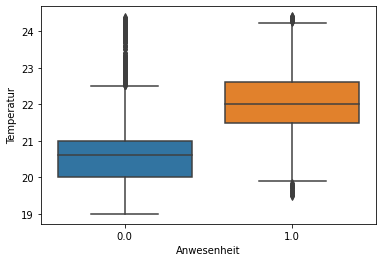

In [ ]:
sns.boxplot(y=raw['Temperatur'],x=raw['Anwesenheit'])

<AxesSubplot:xlabel='Anwesenheit', ylabel='Luftfeuchtigkeit'>

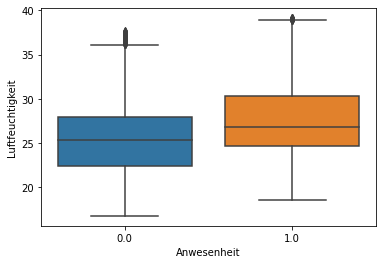

In [11]:
sns.boxplot(y=raw['Luftfeuchtigkeit'], x=raw['Anwesenheit'])

<AxesSubplot:xlabel='Anwesenheit', ylabel='CO2'>

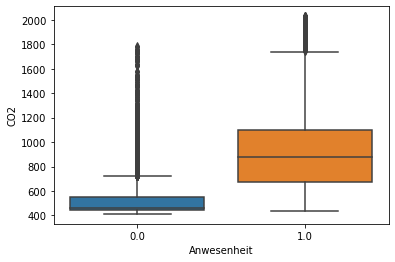

In [12]:
sns.boxplot(y=raw['CO2'],x=raw['Anwesenheit'])

<AxesSubplot:xlabel='Anwesenheit', ylabel='Wassergehalt'>

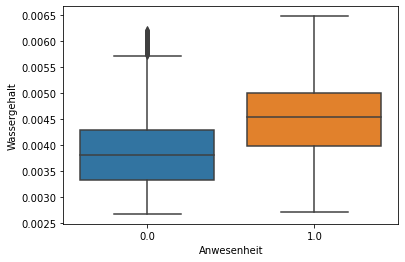

In [13]:
sns.boxplot(y=raw['Wassergehalt'], x=raw['Anwesenheit'])

Ausreißerdefinition nach Boxplots: 1.5 IQA Über oberer Box, da fallen sehr viele Werte drunter.

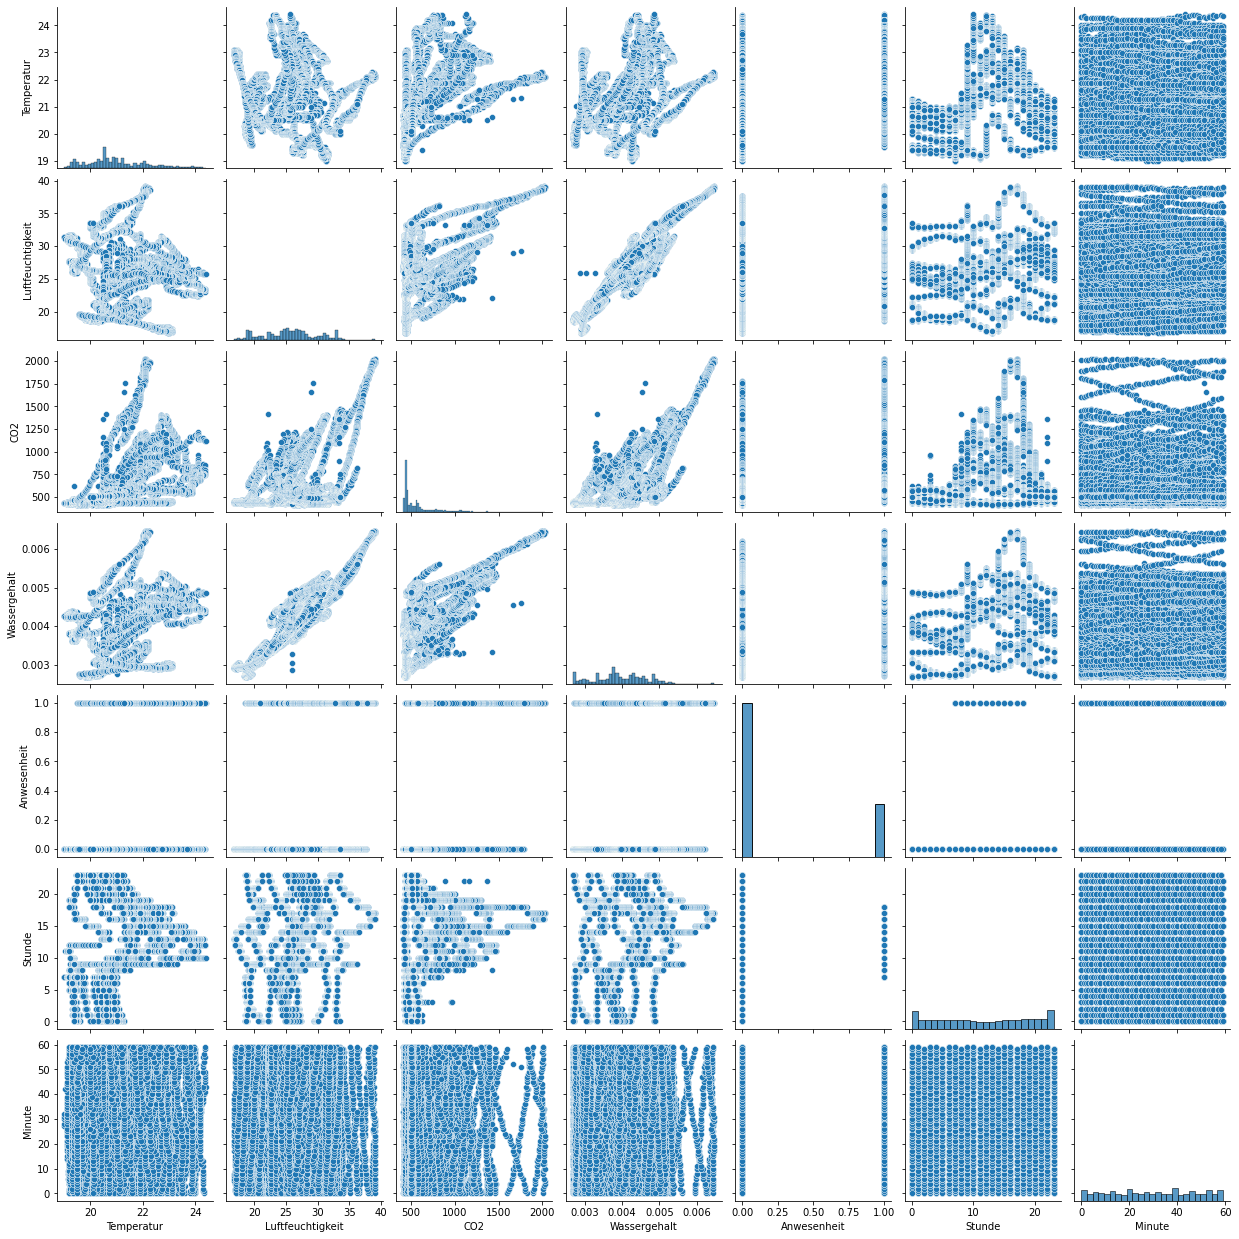

In [17]:
sns.pairplot(raw)

Rechtsschiefe Verteilung von CO2 -> hat auch die meisten Ausreißer

In [18]:
raw.corr()

,Temperatur,Luftfeuchtigkeit,CO2,Wassergehalt,Anwesenheit,Stunde,Minute
Temperatur,1.000000,-0.042913,0.545736,0.345093,0.548405,0.226848,-0.003443
Luftfeuchtigkeit,-0.042913,1.000000,0.410889,0.920885,0.172835,0.157645,-0.001761
CO2,0.545736,0.410889,1.000000,0.614993,0.660436,0.186722,-0.003350
Wassergehalt,0.345093,0.920885,0.614993,1.000000,0.384524,0.235736,-0.003367
Anwesenheit,0.548405,0.172835,0.660436,0.384524,1.000000,0.085595,0.011916
Stunde,0.226848,0.157645,0.186722,0.235736,0.085595,1.000000,0.004099
Minute,-0.003443,-0.001761,-0.003350,-0.003367,0.011916,0.004099,1.000000


- Splate Anwesenheit sollte Angaben über Featurerelevanz geben: CO2,Temperatur,Wassergehalt, Luftfeuchtigkeit
- Wassergehalt abgeleitet aus Temperatur und Luftfeutigkeit -> nur hohe Korrelation mit Luftfeuchtigkeit

In [19]:
raw.groupby('Anwesenheit').mean()

,Temperatur,Luftfeuchtigkeit,CO2,Wassergehalt,Stunde,Minute
Anwesenheit,,,,,,
0.0,20.635511,25.476078,519.714751,0.003825,11.355686,29.402153
1.0,22.077989,27.288847,942.087819,0.004489,12.748152,29.874350


Erkennbare Relevanz aller Features für Unterscheidung Anwesenheit 1/0

<AxesSubplot:xlabel='Stunde', ylabel='count'>

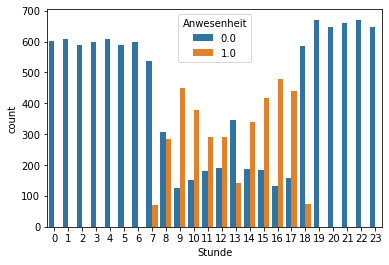

In [20]:
sns.countplot(data=raw, x='Stunde',hue="Anwesenheit")

In [21]:
raw.groupby('Wochentag').mean()

,Temperatur,Luftfeuchtigkeit,CO2,Wassergehalt,Anwesenheit,Stunde,Minute
Wochentag,,,,,,,
Friday,21.225981,23.723132,581.501042,0.003711,0.375000,11.494444,29.522222
Monday,20.880841,29.624476,872.428748,0.004548,0.364671,13.549233,29.707571
Saturday,20.577138,20.654174,443.632963,0.003075,0.000000,11.486468,29.501735
Sunday,19.510642,29.199576,434.117587,0.004091,0.000000,11.494444,29.522222
Thursday,21.600399,24.673302,664.249361,0.003945,0.271875,11.494444,29.522222
Tuesday,21.109308,27.957957,694.449558,0.004336,0.324230,9.441410,29.297418
Wednesday,21.302498,26.873286,594.390475,0.004219,0.255591,13.477955,29.600639


Kein Pimmel ist am Wochenende da

# Random Forest
- Hpyerparameter: Baumtiefe (eigentlich nicht), Anzahl Bäume, Anzahl Features

In [30]:
rfor_x,rfor_y = pipeline(raw)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier

In [31]:
X_train, X_test, y_train, y_test = train_test_split(rfor_x, rfor_y, test_size=0.2, random_state=42)

Cross Validation for Hyperparameters: n_estimators, max_features, max_depth

In [16]:
from sklearn.model_selection import GridSearchCV 
param_grid = {'n_estimators':[10,100,200], #Default is 100
             'max_features':['sqrt','log2'], #Default ist sqrt, log2 other option
             'max_depth':[None,4,6]}, #Default is None, means depth until pure leaves are achieved
scores = ['accuracy', 'precision', 'recall']

gs = GridSearchCV(RandomForestClassifier(criterion = 'entropy', random_state=True),
                 param_grid = param_grid,
                 scoring = scores,
                 refit="recall", # needed for multi param search -> we decide on recall, because we have to minimize occasions, where present = 1 prediction = 0
                 return_train_score=True) # includes Train Scores in cv_results_
gs.fit(X_train,y_train)

KeyboardInterrupt: 

Load CV results in DataFrame for visualization

In [61]:
df = pd.DataFrame(gs.cv_results_)
df

NameError: name 'gs' is not defined

In [57]:
print(f"Ergebnis der CV: \nBestes Modell ist {rf.best_estimator_} \nmit Hyperparametern {rf.best_params_} und einem Recall von {rf.best_score_}")

Ergebnis der CV: 
Bestes Modell ist RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       n_estimators=200, random_state=True) 
mit Hyperparametern {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200} und einem Recall von 0.9835616438356165


Evaluation with best Hyperparameters on Test Data

In [32]:
rf = RandomForestClassifier(n_estimators=200, criterion='entropy', max_features = 'sqrt', random_state = True)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Train Accuracy: ", rf.score(X_train, y_train), "Test Accuracy: ", rf.score(X_test, y_test))
print("Recall: ", recall_score(y_test, y_pred), "Precision: ", precision_score(y_test, y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test, y_pred))
print("Feature Importance: \n", pd.Series(rf.feature_importances_, index=rfor_x.columns).sort_values(ascending=False)) 

Train Accuracy:  1.0 Test Accuracy:  0.9936819936819937
Recall:  0.9863574351978172 Precision:  0.9890560875512996
Confusion Matrix: 
 [[2108    8]
 [  10  723]]
Feature Importance: 
 CO2                    0.283494
Stunde                 0.239889
Temperatur             0.201969
Wassergehalt           0.093032
Luftfeuchtigkeit       0.075168
Minute                 0.035423
Wochentag_Friday       0.014878
Wochentag_Saturday     0.014519
Wochentag_Thursday     0.014075
Wochentag_Sunday       0.011358
Wochentag_Monday       0.006243
Wochentag_Tuesday      0.005844
Wochentag_Wednesday    0.004106
dtype: float64


ROC-Curve

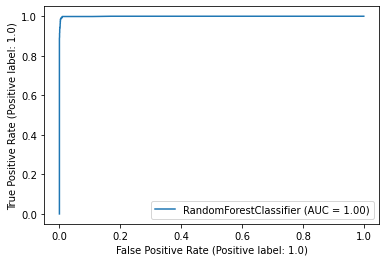

In [33]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.show()

Last Step: Use model on unseen Data (test.csv)

In [37]:
test = pd.read_csv('test.csv')

In [39]:
test.shape

(6319, 6)

In [85]:
X_val,trash = pipeline(test)

In [45]:
X_train, y_train = pipeline(raw)

In [46]:
X_train.columns

Index(['Temperatur', 'Luftfeuchtigkeit', 'CO2', 'Wassergehalt', 'Minute',
       'Stunde', 'Wochentag_Friday', 'Wochentag_Monday', 'Wochentag_Saturday',
       'Wochentag_Sunday', 'Wochentag_Thursday', 'Wochentag_Tuesday',
       'Wochentag_Wednesday'],
      dtype='object')

In [49]:
X_val.columns

Index(['Temperatur', 'Luftfeuchtigkeit', 'CO2', 'Wassergehalt', 'Minute',
       'Stunde', 'Wochentag_Monday', 'Wochentag_Saturday', 'Wochentag_Sunday',
       'Wochentag_Tuesday', 'Wochentag_Wednesday'],
      dtype='object')

Need to add Columns to Test Data that represent non occuring days  in Test Data

In [96]:
X_val['Wochentag_Friday'] = 0
X_val['Wochentag_Thursday'] = 0

Reorder Columns as they were in Train Data

In [63]:
cols =['Temperatur', 'Luftfeuchtigkeit', 'CO2', 'Wassergehalt', 'Minute',
       'Stunde', 'Wochentag_Friday', 'Wochentag_Monday', 'Wochentag_Saturday',
       'Wochentag_Sunday', 'Wochentag_Thursday', 'Wochentag_Tuesday',
       'Wochentag_Wednesday']

Add Prediction Column

In [91]:
X_val['Vorhersage'] = rf.predict(X_val[cols])

In [95]:
X_val.to_csv('RandomForest.csv', index=False)

In [36]:
## Unwichtig!! Hyperparametersuche ohne CV

from itertools import product
n_estimators = [10,100,200] #Default is 100
max_features = ['sqrt','log2'] #Default ist sqrt, log2 other option
max_depth = [None,2,4,6] #Default is None, means depth to pure leaves

for e, f, d in product(n_estimators, max_features, max_depth):
    rf = RandomForestClassifier(n_estimators = e,
                                criterion = 'entropy',
                                max_features = f,
                                max_depth = d,
                                random_state = None,
                                oob_score = True) # When given, keeps Bootstrap & Feature selection constant -> meine Logik: sollte auf False bleiben, damit CV erspart bleibt? (random Bootstraps bei jedem Baum?)
    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test)
    print(f'\n \n RandomForest mit Hyperparametern: \n n_trees: {e}, n_features: {f}, Tiefe: {d}')
    print("Train Accuracy: ", rf.score(X_train, y_train), "Test Accuracy: ", rf.score(X_test, y_test))
    print("Recall: ", recall_score(y_test, y_pred), "Precision: ", precision_score(y_test, y_pred))
    print("Confusion Matrix: \n",confusion_matrix(y_test, y_pred))
    print("Feature Importance: \n", pd.Series(rf.feature_importances_, index=rfor_x.columns).sort_values(ascending=False)) 

C:\Users\torbe\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\torbe\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\torbe\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\torbe\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\torbe\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were 


 
 RandomForest mit Hyperparametern: 
 n_trees: 10, n_features: sqrt, Tiefe: None
Train Accuracy:  0.9994733146067416 Test Accuracy:  0.991926991926992 OOB Score:  0.9860428370786517
Recall:  0.9809004092769441 Precision:  0.9876373626373627
Confusion Matrix: 
 [[2107    9]
 [  14  719]]
Feature Importance: 
 Stunde                 0.291854
CO2                    0.269875
Temperatur             0.165118
Luftfeuchtigkeit       0.089228
Wassergehalt           0.084583
Minute                 0.034600
Wochentag_Friday       0.016865
Wochentag_Thursday     0.014621
Wochentag_Sunday       0.013148
Wochentag_Saturday     0.007616
Wochentag_Tuesday      0.005121
Wochentag_Monday       0.004759
Wochentag_Wednesday    0.002611
dtype: float64

 
 RandomForest mit Hyperparametern: 
 n_trees: 10, n_features: sqrt, Tiefe: 2
Train Accuracy:  0.913184691011236 Test Accuracy:  0.9231309231309232 OOB Score:  0.8805301966292135
Recall:  0.8049113233287858 Precision:  0.8858858858858859
Confusion Matrix:

C:\Users\torbe\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\torbe\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\torbe\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /


Recall:  0.8894952251023193 Precision:  0.8704939919893191
Confusion Matrix: 
 [[2019   97]
 [  81  652]]
Feature Importance: 
 Stunde                 0.383702
CO2                    0.208534
Temperatur             0.143352
Wassergehalt           0.101929
Luftfeuchtigkeit       0.070653
Wochentag_Sunday       0.031481
Wochentag_Saturday     0.027469
Wochentag_Friday       0.026399
Wochentag_Tuesday      0.002614
Wochentag_Wednesday    0.002306
Minute                 0.001561
Wochentag_Monday       0.000000
Wochentag_Thursday     0.000000
dtype: float64

 
 RandomForest mit Hyperparametern: 
 n_trees: 10, n_features: sqrt, Tiefe: 6
Train Accuracy:  0.9637464887640449 Test Accuracy:  0.9673569673569674 OOB Score:  0.9490870786516854
Recall:  0.9522510231923602 Precision:  0.9232804232804233
Confusion Matrix: 
 [[2058   58]
 [  35  698]]
Feature Importance: 
 CO2                    0.306519
Stunde                 0.266550
Temperatur             0.227370
Wassergehalt           0.081536
Luf

C:\Users\torbe\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\torbe\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\torbe\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\torbe\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\torbe\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were 


 
 RandomForest mit Hyperparametern: 
 n_trees: 10, n_features: log2, Tiefe: None
Train Accuracy:  0.9992099719101124 Test Accuracy:  0.9898209898209899 OOB Score:  0.9853405898876404
Recall:  0.9727148703956344 Precision:  0.9875346260387812
Confusion Matrix: 
 [[2107    9]
 [  20  713]]
Feature Importance: 
 CO2                    0.303232
Stunde                 0.260116
Temperatur             0.163120
Wassergehalt           0.097622
Luftfeuchtigkeit       0.081603
Minute                 0.030599
Wochentag_Friday       0.017760
Wochentag_Saturday     0.012304
Wochentag_Thursday     0.009978
Wochentag_Sunday       0.008991
Wochentag_Tuesday      0.006174
Wochentag_Monday       0.005891
Wochentag_Wednesday    0.002611
dtype: float64

 
 RandomForest mit Hyperparametern: 
 n_trees: 10, n_features: log2, Tiefe: 2
Train Accuracy:  0.9174859550561798 Test Accuracy:  0.9245349245349246 OOB Score:  0.8833391853932584
Recall:  0.8321964529331515 Precision:  0.8689458689458689
Confusion Matri

C:\Users\torbe\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\torbe\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /



 
 RandomForest mit Hyperparametern: 
 n_trees: 100, n_features: sqrt, Tiefe: None
Train Accuracy:  1.0 Test Accuracy:  0.9933309933309933 OOB Score:  0.9911341292134831
Recall:  0.9863574351978172 Precision:  0.9877049180327869
Confusion Matrix: 
 [[2107    9]
 [  10  723]]
Feature Importance: 
 CO2                    0.313204
Stunde                 0.240824
Temperatur             0.171985
Wassergehalt           0.092937
Luftfeuchtigkeit       0.077696
Minute                 0.034603
Wochentag_Friday       0.015523
Wochentag_Thursday     0.014161
Wochentag_Saturday     0.012894
Wochentag_Sunday       0.011598
Wochentag_Monday       0.005866
Wochentag_Tuesday      0.005069
Wochentag_Wednesday    0.003641
dtype: float64

 
 RandomForest mit Hyperparametern: 
 n_trees: 100, n_features: sqrt, Tiefe: 2
Train Accuracy:  0.8891327247191011 Test Accuracy:  0.8982098982098982 OOB Score:  0.8917661516853933
Recall:  0.7967257844474761 Precision:  0.8055172413793104
Confusion Matrix: 
 [[1975  